# PCA Statistical Arbitrage

(This notebook can be found on GitHub: https://github.com/rodler/quantinsti_statarb)

### Dr Tom Starke 

*Homepage: www.aaaquants.com *

*Email: tom@aaaquants.com *

*Linkedin: Dr Tom Starke *

### What we will learn:
- Building a PCA manually
- Modelling vol curves
- Building a stock index
- Conduct a pairs-trading backtest using PCA
- Sector statistical arbitrage using PCA

In [1]:
pip install yfinance

     |████████████████████████████████| 63 kB 705 kB/s 
     |████████████████████████████████| 6.4 MB 8.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint, grangercausalitytests
import matplotlib
from itertools import groupby, count
import pickle
import yfinance as yf
from dateutil.parser import parse
import datetime
from scipy.optimize import brentq 
import traceback
from google.colab import files
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Build PCA from Scratch

#### First, we create a random seed for consistency

In [3]:
np.random.seed(20)

#### Create a random time series

We make it look like a price series, which starts at 100 dollars.

In [4]:
x = np.cumsum(np.random.randn(200)) + 100
x

array([100.88389311, 101.07975813, 101.43729465,  99.09403274,
        98.00920016,  98.56889645,  99.5083658 ,  98.52988475,
        99.03298159,  99.43939606,  99.76285707,  99.26944619,
        98.4774294 ,  97.63506147,  96.35555881,  96.60127397,
        96.55707917,  98.12471173,  99.17582041,  99.58218883,
        99.41354273,  96.22383994,  97.3439722 ,  98.67675041,
        98.43341164,  98.30338093,  98.19436356,  99.75055   ,
        99.87932835,  97.81237963,  96.92688647,  95.82230699,
        96.75517334,  98.81501134,  97.88007338,  96.26708316,
        96.79415288,  95.24305215,  95.57266549,  94.43613895,
        94.09764834,  94.41861913,  93.81631111,  95.36103947,
        96.00807355,  96.60129076,  97.03931526,  98.39710428,
        99.60161555, 100.95341174, 101.44684897,  98.74248373,
        98.18729793,  98.18880649,  99.04590031, 100.52704395,
       100.30738283, 101.81078099, 100.32839594,  99.47223172,
        98.64353895,  98.75758655,  99.28531502,  99.44

#### Produce a second series with the same behaviour but higher standard deviation.

In [5]:
y = x*2 + np.random.randn(200) - 100
y

array([100.2638084 , 103.4734841 , 102.8444632 ,  98.82307857,
        96.52083555,  98.29975881,  98.7109833 ,  98.77205228,
        99.23540019,  98.60297725,  97.01393344,  98.12162057,
        97.49643126,  95.12501563,  91.68953488,  93.67482592,
        92.40603484,  97.66356293,  97.86110765, 100.34554853,
        98.78016035,  90.98757371,  94.1797529 ,  96.85828506,
        97.62860938,  94.95991812,  97.24265348,  99.49314007,
        98.86918152,  95.97826689,  93.31434219,  92.23574673,
        93.39205318,  97.26954971,  94.69151465,  93.42488371,
        93.82355736,  90.3935445 ,  90.63426779,  89.46610057,
        87.42122185,  87.76631585,  87.00568488,  89.6447158 ,
        93.29312694,  93.54904286,  93.95631458,  97.01337812,
        99.34669818, 103.34166824, 103.94906234,  98.60026038,
        98.17560226,  96.18319415,  97.24961358,  99.90591323,
        99.78322172, 102.94881537, 101.32690833,  97.79559075,
        97.01917049,  96.5636105 ,  97.00056141,  99.86

#### Plot both series

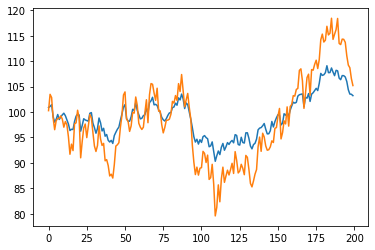

In [6]:
plt.plot(x)
plt.plot(y)

#### Fist PCA step: De-Meaning of series

In [7]:
x_ = x-np.mean(x)
y_ = y-np.mean(y)

#### Collect de-meaned series in an array

In [8]:
R = np.array([x_,y_])
R

array([[ 1.82296326e+00,  2.01882828e+00,  2.37636480e+00,
         3.31028945e-02, -1.05172969e+00, -4.92033403e-01,
         4.47435946e-01, -5.31045096e-01, -2.79482556e-02,
         3.78466213e-01,  7.01927223e-01,  2.08516341e-01,
        -5.83500449e-01, -1.42586838e+00, -2.70537105e+00,
        -2.45965588e+00, -2.50385068e+00, -9.36218124e-01,
         1.14890556e-01,  5.21258982e-01,  3.52612880e-01,
        -2.83708991e+00, -1.71695765e+00, -3.84179441e-01,
        -6.27518207e-01, -7.57548919e-01, -8.66566290e-01,
         6.89620149e-01,  8.18398502e-01, -1.24855022e+00,
        -2.13404338e+00, -3.23862286e+00, -2.30575651e+00,
        -2.45918511e-01, -1.18085647e+00, -2.79384669e+00,
        -2.26677697e+00, -3.81787770e+00, -3.48826436e+00,
        -4.62479090e+00, -4.96328151e+00, -4.64231073e+00,
        -5.24461874e+00, -3.69989038e+00, -3.05285630e+00,
        -2.45963909e+00, -2.02161459e+00, -6.63825574e-01,
         5.40685701e-01,  1.89248189e+00,  2.38591912e+0

#### Calculate the covariance matrix of the array

In [9]:
S = np.cov(R)
S

array([[17.01547369, 33.69556579],
       [33.69556579, 67.62804956]])

#### Calculate the eigenvalues and eigenvectors of the covariance matrix

In [10]:
EIG = np.linalg.eig(S)

#### Eigenvalues:

In [11]:
print(EIG[0])

[ 0.18152713 84.46199612]


#### Eigenvectors:

Each eigenvector is one column of this matrix

We can see that the vectors are orthogonal to each other. This is also true for eigenvectors of higher dimensionality.

In [12]:
EV = EIG[1]
print(EV)

[[-0.89457408 -0.4469197 ]
 [ 0.4469197  -0.89457408]]


#### Plotting the eigenvectors

First, we create some x-values from the array R containing our time series.

In [13]:
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)

#### Calculating the slopes

$dx_{1} = ev_{0,0} - 0$

$dy_{1} = ev_{1,0} - 0$

$dx_{2} = ev_{0,1} - 0$

$dy_{2} = ev_{1,1} - 0$

#### Slope of first eigenvector

In [14]:
dx1 = EV[0,0]
dy1 = EV[1,0]
slope1 = dy1 / dx1

#### Slope of second eigenvector

In [15]:
dx2 = EV[0,1]
dy2 = EV[1,1]
slope2 = dy2 / dx2

#### Multiply the slopes with the x-values to generate the corresponding y-values for each vector

In [16]:
yy1 = slope1 * xx
yy2 = slope2 * xx

#### Now we can plot the eigenvectors

We plot the eigenvectors along with the underlying 

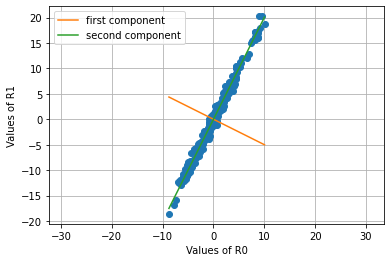

In [17]:
# Plot de-meaned x - y correlation
plt.plot(R[0,:],R[1,:],'o')

# Plot the first principal component
plt.plot(xx,yy1,label='first component')

# Plot the second principal component
plt.plot(xx,yy2,label='second component')

plt.legend()

plt.xlabel('Values of R0')

plt.ylabel('Values of R1')

plt.grid()

plt.axis('equal');

The higher expanatory value of component2 is reflected in the eigenvalues: 



In [18]:
print(EIG[0])

[ 0.18152713 84.46199612]


## Example 1: Vol-Curve Modelling

A very common use case for PCA is the modelling of yield curves for bonds or implied volatility curves for options. Here, we look at implied volatility (IV). 
The IV of an option tells you whether the option is relatively cheap or expensive. The X-axis is expressed in deltas, which is a way to normalize the strike prices of options. An ATM or at-the-money option (where the strike is closest to the price of the underlying stock) usually has a delta close to 0.5 while ITM, or in-the-money options have deltas>0.5 and OTM (out-of-the-money) options have deltas less than 0.5 .

In our example here we use the vol-curves for OTM put options.

Let's first upload some vol-curve data:

In [19]:
# Upload 'vol_curves.pick' and un-pickle it.
uploaded = files.upload()

Saving vol_curves.pick to vol_curves.pick


In [20]:
vol_curves = pickle.load(open('vol_curves.pick','rb'))

Text(0, 0.5, 'implied volatility')

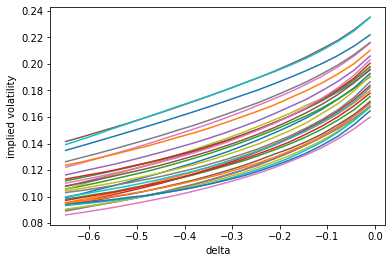

In [21]:
delta = np.linspace(-0.65,-0.01,20)
for curve in vol_curves:
  plt.plot(delta,curve)

plt.xlabel('delta')
plt.ylabel('implied volatility')

Next, we perform the PCA and plot the most significant principle components. The cumulative sum of them is also called the "explained variance". We can see that out of the 30 components, the 4 most significant once can explain almost 100% of the variance.

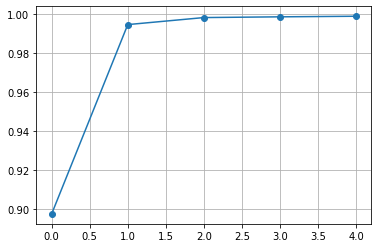

In [22]:
eig = np.linalg.eig(np.cov((vol_curves-np.mean(vol_curves,axis=0))))

plt.plot(np.cumsum(np.real((np.sort(eig[0])[-5:])[::-1]/sum(eig[0]))),'-o')
plt.grid()

In some cases, such as in curve modelling, principal components actually have a meaning. The first three components in vol-curves denote the level, slope and curvature of the curves. With that, we would be able to reconstruct our vol-curves quite accurately. For the sake of demonstration and simplicity we only demonstrate a very crude approximation here. 

Let's have a look how we can do this:

### Level of the Vol Curve

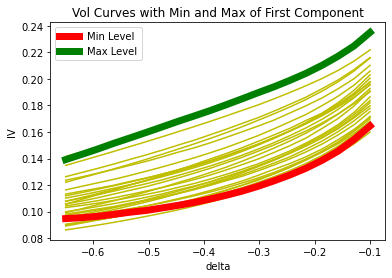

In [23]:
X = np.linspace(-0.65,-0.1,20)
for n in vol_curves:
  plt.plot(X,n,'y')
max_level = np.argmax(np.real(eig[1])[:,0])
min_level = np.argmin(np.real(eig[1])[:,0])
plt.plot(X,vol_curves[max_level],'r-',lw=7,label='Min Level')
plt.plot(X,vol_curves[min_level],'g-',lw=7,label='Max Level')
plt.xlabel('delta')
plt.ylabel('IV')
plt.title('Vol Curves with Min and Max of First Component')
plt.legend()

### Curvature of the Vol Curve

curvature: 0.007886463858959025
curvature: 0.0067534898690382456
curvature: 0.006744818036329023
curvature: 0.008132509951451011
curvature: 0.008744329681090637
curvature: 0.007648235964239067
curvature: 0.0070913399157014195
curvature: 0.00690018481196282
curvature: 0.007782693084117498
curvature: 0.009489105587569088
curvature: 0.009561085028184396
curvature: 0.00783978819383055
curvature: 0.008007345541393665
curvature: 0.007331953769233485
curvature: 0.006319386105640298
curvature: 0.006020794805663782
curvature: 0.006558010927987856
curvature: 0.005913353970232682
curvature: 0.0051524968391334774
curvature: 0.0062482923776809585
curvature: 0.004962718579029135
curvature: 0.007529818083328796
curvature: 0.007718209594251874
curvature: 0.008964219707787907
curvature: 0.007899899532307186
curvature: 0.007666420160095
curvature: 0.00925788675443448
curvature: 0.010192498467904695
curvature: 0.009539427354401109
curvature: 0.00863161360114846
Max curvature: 0.00925788675443448


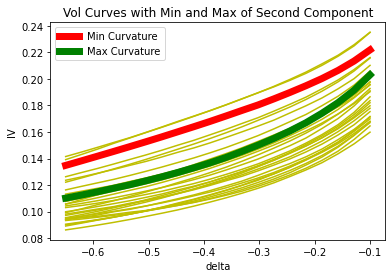

In [24]:
X = np.linspace(-0.65,-0.1,20)
for n in vol_curves:
  plt.plot(X,n,'y')
  print('curvature:',sum(np.diff(n,2)))
max_level = np.argmax(np.real(eig[1])[:,1])
min_level = np.argmin(np.real(eig[1])[:,1])
plt.plot(X,vol_curves[max_level],'r-',lw=7,label='Min Curvature')
plt.plot(X,vol_curves[min_level],'g-',lw=7,label='Max Curvature')
plt.xlabel('delta')
plt.ylabel('IV')
plt.title('Vol Curves with Min and Max of Second Component')
plt.legend()
print('Max curvature:',sum(np.diff(vol_curves[min_level],2)))

### Tilt of the Vol Curve

tilt: 0.09356460691508237
tilt: 0.08438601164857384
tilt: 0.08457507697054834
tilt: 0.08967622399256955
tilt: 0.08174408695818951
tilt: 0.07740195686434292
tilt: 0.07368297984119891
tilt: 0.07887439503616842
tilt: 0.0765572789787289
tilt: 0.07469481116228247
tilt: 0.06982295398466591
tilt: 0.07492566756796991
tilt: 0.07727690727294456
tilt: 0.08075987723826514
tilt: 0.0877703204190507
tilt: 0.09368547502865793
tilt: 0.09359317319103119
tilt: 0.08982263782484295
tilt: 0.09168578559899646
tilt: 0.09587955891665123
tilt: 0.08705921177408801
tilt: 0.08659340941433559
tilt: 0.08600911548257575
tilt: 0.08731938473892188
tilt: 0.08956043296714612
tilt: 0.08787943810321924
tilt: 0.09288369240163902
tilt: 0.08348055194664973
tilt: 0.08676232845244691
tilt: 0.0821600704933817
Max tilt: 0.09587955891665123


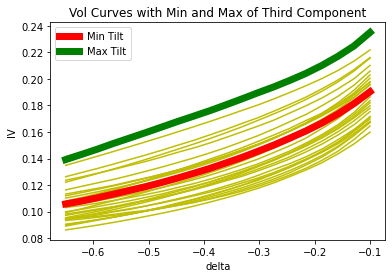

In [25]:
X = np.linspace(-0.65,-0.1,20)
for n in vol_curves:
  plt.plot(X,n,'y')
  print('tilt:',sum(np.diff(n,1)))
max_level = np.argmax(np.real(eig[1])[:,2])
min_level = np.argmin(np.real(eig[1])[:,2])
plt.plot(X,vol_curves[max_level],'r-',lw=7,label='Min Tilt')
plt.plot(X,vol_curves[min_level],'g-',lw=7,label='Max Tilt')
plt.xlabel('delta')
plt.ylabel('IV')
plt.title('Vol Curves with Min and Max of Third Component')
plt.legend()
print('Max tilt:',sum(np.diff(vol_curves[min_level],1)))

Here we go, we just built a three component model for vol-curves. More advanced versions of this are often used in vol-curve arbitrage trades.

## Exanple 2: Building A Stock Index

This is not particularly exciting but it gets really interesting when we use a range of instruments and build an index. Let's build a FAANG index. First, we download the data.

In [26]:
data = yf.download("AMZN AAPL GOOG MSFT", start="2010-06-01")

[*********************100%***********************]  4 of 4 completed


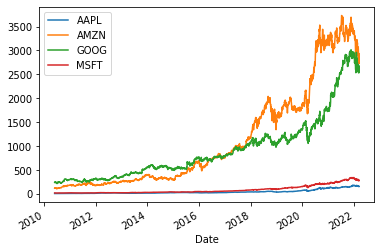

In [27]:
data['Adj Close'].plot()

In [28]:
data

Adj Close                                             Close  \
                  AAPL         AMZN         GOOG        MSFT        AAPL   
Date                                                                       
2010-06-01    7.976498   123.239998   240.284348   20.139284    9.315357   
2010-06-02    8.071913   126.309998   245.763824   20.582680    9.426786   
2010-06-03    8.046527   128.759995   251.855988   20.893837    9.397143   
2010-06-04    7.827570   122.769997   248.428833   20.061499    9.141429   
2010-06-07    7.674051   122.010002   241.853470   19.672562    8.962143   
...                ...          ...          ...         ...         ...   
2022-03-07  159.300003  2749.060059  2529.290039  278.910004  159.300003   
2022-03-08  157.440002  2720.290039  2545.570068  275.850006  157.440002   
2022-03-09  162.949997  2785.580078  2677.320068  288.500000  162.949997   
2022-03-10  158.520004  2936.350098  2653.639893  285.589996  158.520004   
2022-03-11  154.729996  2910.489990  2609.510010  280.070007  154.729996   

                                                        High               \
                   AMZN         GOOG        MSFT        AAPL         AMZN   
Date                                                                        
2010-06-01   123.239998   240.284348   25.889999    9.497857   126.570000   
2010-06-02   126.309998   245.763824   26.459999    9.457143   126.430000   
2010-06-03   128.759995   251.855988   26.860001    9.483929   129.149994   
2010-06-04   122.769997   248.428833   25.790001    9.353571   128.199997   
2010-06-07   122.010002   241.853470   25.290001    9.255357   126.610001   
...                 ...          ...         ...         ...          ...   
2022-03-07  2749.060059  2529.290039  278.910004  165.020004  2921.889893   
2022-03-08  2720.290039  2545.570068  275.850006  162.880005  2813.989990   
2022-03-09  2785.580078  2677.320068  288.500000  163.410004  2805.000000   
2022-03-10  2936.350098  2653.639893  285.589996  160.389999  2973.489990   
2022-03-11  2910.489990  2609.510010  280.070007  159.279999  2993.500000   

            ...          Low                    Open               \
            ...         GOOG        MSFT        AAPL         AMZN   
Date        ...                                                     
2010-06-01  ...   239.163559   25.520000    9.274643   124.970001   
2010-06-02  ...   239.831055   25.730000    9.447857   124.019997   
2010-06-03  ...   246.426331   26.410000    9.470714   126.250000   
2010-06-04  ...   247.422592   25.620001    9.221786   126.330002   
2010-06-07  ...   240.672897   25.240000    9.224643   125.839996   
...         ...          ...         ...         ...          ...   
2022-03-07  ...  2528.199951  278.529999  163.360001  2908.870117   
2022-03-08  ...  2517.215088  270.000000  158.820007  2733.669922   
2022-03-09  ...  2601.760010  280.779999  161.479996  2790.000000   
2022-03-10  ...  2628.020020  280.579987  160.199997  2913.699951   
2022-03-11  ...  2605.929932  279.429993  158.929993  2991.489990   

                                        Volume                              
                   GOOG        MSFT       AAPL     AMZN     GOOG      MSFT  
Date                                                                        
2010-06-01   239.317978   25.530001  876472800  3659500  5353592  76152400  
2010-06-02   242.431305   26.059999  688548000  4764700  5100647  65718800  
2010-06-03   246.630569   26.549999  650106800  5276900  7328767  67837000  
2010-06-04   248.926956   26.100000  758304400  5497700  7869988  89832200  
2010-06-07   248.598190   25.820000  886942000  6566400  7292633  80456200  
...                 ...         ...        ...      ...      ...       ...  
2022-03-07  2638.080078  288.529999   96418800  4346700  1958900  43157200  
2022-03-08  2525.010010  277.799988  131148300  4583100  1762500  48159500  
2022-03-09  2628.000000  283.440002   91454900  4132800

#### First, plot the normalized dataset

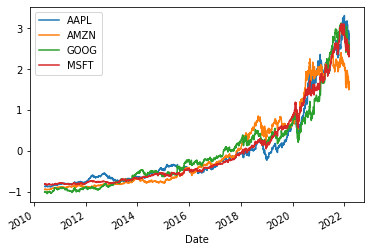

In [29]:
normalized = (data['Adj Close']-data['Adj Close'].mean())/data['Adj Close'].std()
normalized.plot()

#### Running PCA with the Sklearn PCA function

Luckily, we don't need to build our own PCA function as Sklear can do this for us very easily.

The first principal component is the linear combination of the input data that explains most of the variance

In [30]:
pca = PCA(1).fit(data['Adj Close'].values.T)

#### Generate the index from the principal components

In [31]:
index=pca.components_[0].T

#### Plot the index of the FAANG stocks

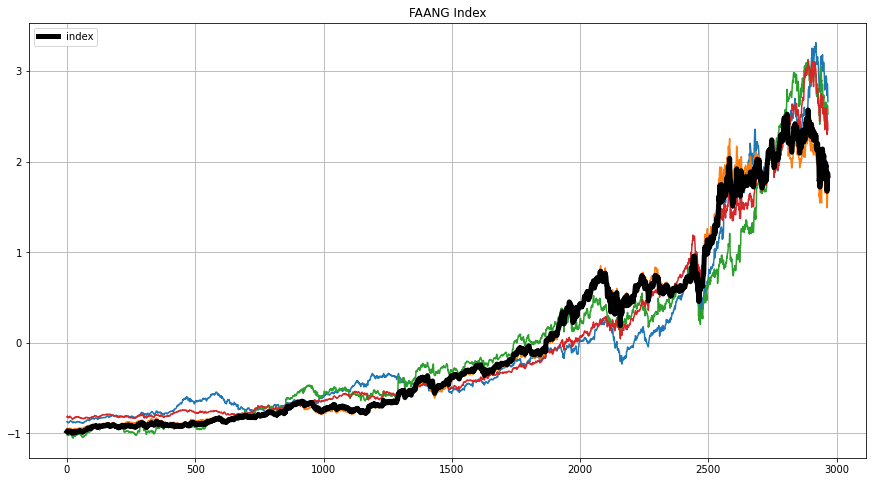

In [32]:

plt.figure(figsize=[15,8])
plt.plot(normalized.values)
plt.plot((index-np.mean(index))/np.std(index),'k',lw=5,label='index')
plt.legend()
plt.title('FAANG Index')
plt.grid();


## Cointegration

### Short recap: cointegration versus correlation

- Cointegrated price series do not necessarily have to be correlated and vice-versa 

- Drunk and her dog: https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction

- Same behaviour in the markets and causality relationships change. For more information please refer to Engle-Granger causality (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjcvKPcsqDeAhXTbCsKHTmNAe8QFjAAegQIBxAB&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FGranger_causality&usg=AOvVaw1mYq3HhcjsVNJ9zJ6zgqdV)


Engel-Granger Causality

#### Simulating Cointegration

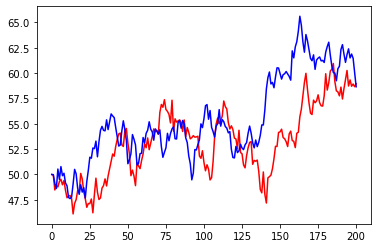

In [33]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.0])
plt.plot(X,'r-',Y,'b-');

#### Cointegration Test

coint uses the augmented Engle-Granger two-step cointegration test.

In [34]:
coint(X,Y)

(-2.9492838126712733,
 0.12275827117520316,
 array([-3.95203768, -3.36685108, -3.065724  ]))

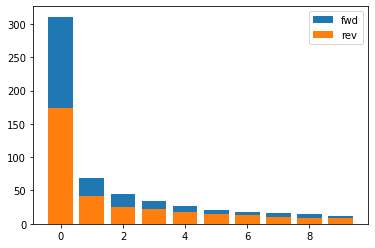

In [35]:
X,Y = make_coint_0(200,T0=[50,50],c=[0.8,0.6])

lags = 10

# Calculating the EG-Test in one direction
result = grangercausalitytests(np.array([X,Y]).T, lags, verbose=False)

# Extracting results
res_fwd = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

# Calculating the EG-Test in reverse direction
result = grangercausalitytests(np.array([Y,X]).T, lags, verbose=False)

# Extracting results
res_rev = [(list(result.values())[lag][0]['ssr_ftest'][0]) for lag in range(lags)]

plt.bar(range(lags),res_fwd,label='fwd')
plt.bar(range(lags),res_rev,label='rev')
plt.legend()

#### Cointegration of FAANG stocks

In [36]:
coints = []
for i in range(data['Adj Close'].values.shape[1]):
    for k in range(i,data['Adj Close'].values.shape[1]):
        if not i==k:
            coints.append(coint(data['Adj Close'].values.T[i],data['Adj Close'].values.T[k])[0])

            print(i,k,coints[-1])

0 1 -0.7452870335131291
0 2 -3.0090650650776025
0 3 -3.0724178219408596
1 2 -1.1843721615468112
1 3 -1.4522209532022463
2 3 -2.3354123815539625


## Example 3: Statistical Arbitrage

First, we define some functions for PCA and Z-score.

In [37]:
def get_resids(d,N=1):
  pca = PCA(N).fit(d.T)
  index=pca.components_[0]
  mm = [sm.OLS(s, index).fit() for s in d.T]
  return list(map(lambda x: x.resid, mm))

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

#### Next, we download some data from Yahoo Finance.

In [38]:
data2 = yf.download("AAPL NFLX", start="2019-01-01", end="2021-05-30")

[*********************100%***********************]  2 of 2 completed


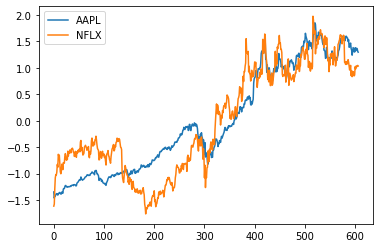

(-1.927761001635139,
 0.5658634149874986,
 array([-3.91460374, -3.34623125, -3.05145609]))

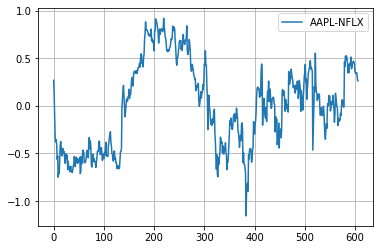

In [39]:
aapl = data2['Adj Close']['AAPL']
nflx = data2['Adj Close']['NFLX']
plt.plot(Zscore(aapl),label='AAPL')
plt.plot(Zscore(nflx),label='NFLX')
plt.legend()
plt.show()

plt.plot(Zscore(aapl)-Zscore(nflx),label='AAPL-NFLX')
plt.grid()
plt.legend()
coint(Zscore(aapl),Zscore(nflx))

#### A simple pairs trading backtest

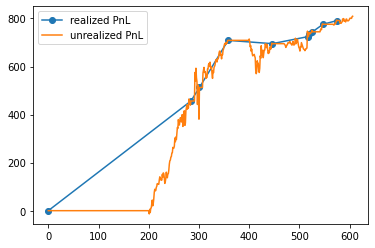

In [40]:
def backtest(aapl,nflx,th):
  inpos = 0
  lkbk = 200
  pnls = [0]
  idxs = [0]
  unrlzd = []
  hedge_ratio = 0

  for i in range(len(aapl)):
    # GET DATA FROM MARKET
    unr = ((aapl[i]*hedge_ratio - nflx[i]) - (aapl[i-1]*hedge_ratio - nflx[i-1]))*inpos
    unrlzd.append(unr)

    if i<lkbk:
      continue


    za = Zscore(aapl[i-lkbk:i])
    zn = Zscore(nflx[i-lkbk:i])

    signal = za[-1] - zn[-1]
    if not inpos:
      pca = PCA(1).fit(np.array([aapl[i-lkbk:i],nflx[i-lkbk:i]]).T)
      hedge_ratio = pca.components_[0,1]/pca.components_[0,0]

    if inpos==0 and signal<-th:
      entry = aapl[i]*hedge_ratio - nflx[i] 
      # SEND ENTRY ORDERS TO MARKET
      inpos = 1

    elif inpos>0 and signal>0:
      pnl =  (aapl[i]*hedge_ratio - nflx[i]) - entry
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)

    if inpos==0 and signal>th:
      entry =  aapl[i]*hedge_ratio - nflx[i]
      inpos = -1

    elif inpos<0 and signal<0:
      pnl = entry - (aapl[i]*hedge_ratio - nflx[i])
      inpos = 0
      pnls.append(pnl)
      idxs.append(i)

  return idxs,pnls,unrlzd

idxs,pnls,unrlzd = backtest(aapl,nflx,0.6)
plt.plot(idxs,np.cumsum(pnls),'-o',label='realized PnL');
plt.plot(np.cumsum(unrlzd),label='unrealized PnL')
plt.legend()

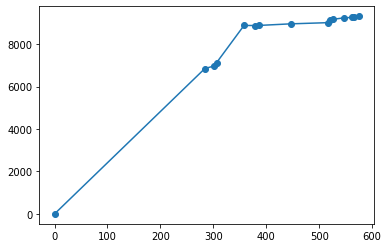

In [41]:
ths = np.linspace(0.4,2.6,15)
ts = []
for th in ths:
  idxs,pnls,unrlzd = backtest(aapl,nflx,th)
  ts.append(pd.Series(pnls,index=idxs))

df = pd.DataFrame(ts).T.fillna(0)

plt.plot(df.cumsum().sum(axis=1),'-o')

## Example 4: Portfolio Statarb

Here we apply statistical arbitrage to a portfolio. I some sense, this is a generalization of pairs trading. We rank the stocks with PCA and create a long/short portfolio with N long and N short stocks, where N is set by "max_pos". Make sure N is less then half the number of stocks in your universe.

In [48]:
pr = np.array(data['Adj Close'].ffill()).T
max_pos=2
initial_cash=1e6
LKBK = 50

entry = {} # create a vector of entry prices
pnls = [] # create a pnl vector

# Exit if we specified too large long/short position size
if max_pos > pr.shape[0]/2:
    print('max_pos too large!')
    adfadsf

# loop through the prices
for i,pri in enumerate(pr.T):

    # Make sure you have enough data points for PCA
    if i < LKBK: continue

    # Run the PCA, only on the past prices
    resids = get_resids(pr.T[max([0,i-LKBK]):i],1)
    zs = {}

    # Calculate the z-scores for each instrument. 
    for inst in range(len(pri)):
        try: zs[inst] = Zscore(resids[inst])[-1]
        except: 
          print(traceback.format_exc())

    pnl = 0
    # Calculate the Pnl for each position over the prevoius period
    for j,idx in enumerate(entry):

        # Calculate the position size
        # The sign of the position depends on the sign of the entry price
        pos = np.round((initial_cash/max_pos)/entry[idx])

        # Add up the pnls for all positions for the last period
        # We neutralize the sign of the entry price and let it 
        # come in through the position.

        if pos>0:
          pnl += (pri[idx]-np.abs(entry[idx]))*pos
        
    pnls.append(pnl)

    # Reset the portfolio
    entry = {}

    # Find the new instruments to be traded based on their z-scores
    idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
    idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])

    # Add them to the entry list
    # The entry gets a positive or negative sign depending on the side of the trade
    for idx in idx_long:
        entry[idx] = pri[idx]
    for idx in idx_short:
        entry[idx] = -pri[idx]

    #print(i,sum(pnls))

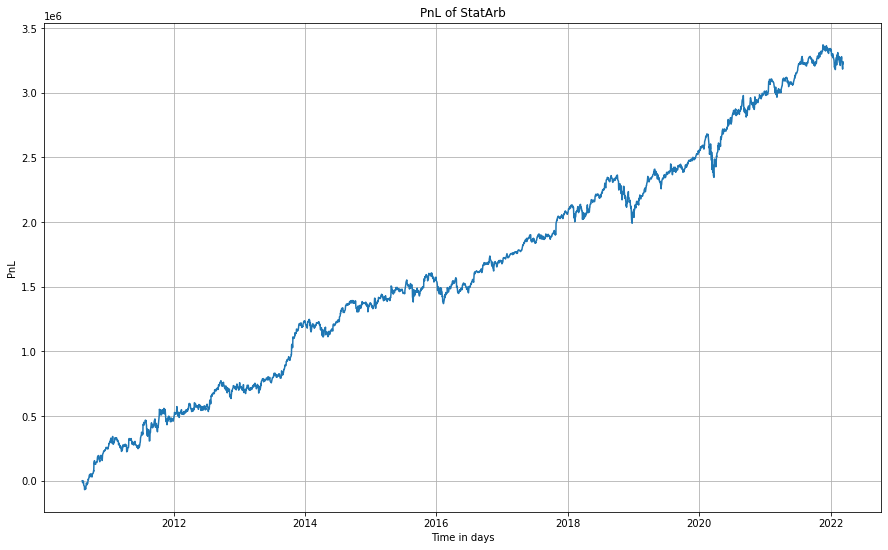

In [49]:
plt.figure(figsize=[15,9])
plt.plot(data.index[-len(pnls):],np.cumsum(pnls))
plt.title('PnL of StatArb')
plt.xlabel('Time in days')
plt.ylabel('PnL')
plt.grid()